In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import seaborn as sb
sb.set()

In [2]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
experiment_logs = './results/booking_config_ltr_2021_02_01T10_23_10/stdout'
data = get_data_from_logs(experiment_logs, 0)

In [5]:
df = pd.DataFrame(data).set_index('model_name').sort_values('SPS@4')
df.sort_values('precision@4')

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
Lightgbm-rf-regression,0.118122,0.472486,0.360950,0.443473,817.737178,55.368318,{},[]
Lightgbm-rf-huber,0.118559,0.474237,0.366262,0.447858,865.299247,56.297848,{},[]
Lightgbm-rf-poisson,0.118559,0.474237,0.362486,0.444159,848.888479,56.260915,{},[]
APREC-Lightgbm-RF-Regression,0.118809,0.475238,0.366566,0.442656,168.274750,45.318294,{},[]
Lightgbm-rf-tweedie,0.118872,0.475488,0.362768,0.443972,843.297673,56.234466,{},[]
Lightgbm-rf-mape,0.118997,0.475988,0.360629,0.442056,845.748608,56.199901,{},[]
Lightgbm-gbdt-regression,0.119247,0.476988,0.364376,0.443732,832.330156,71.776938,{},[]
Lightgbm-rf-regression_l1,0.119622,0.478489,0.362637,0.441968,942.026015,60.368576,{},[]
Lightgbm-rf-fair,0.119685,0.478739,0.363254,0.443074,865.241040,56.086330,{},[]


No handles with labels found to put in legend.


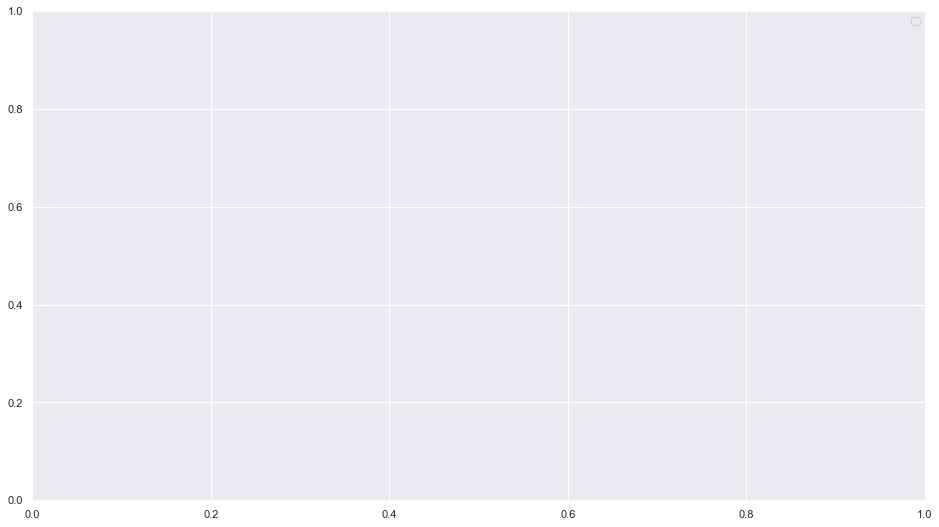

In [6]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = moving_average(get_metric(history, 'val_ndcg_at_40'), 1)
        
        success = get_metric(history, 'Success_at_4')
        val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        
        plt.plot(val_ndcg, label=recommender['model_name'] + "val_ndcg")
        plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [7]:
np.argmax(val_ndcg)

NameError: name 'val_ndcg' is not defined

In [ ]:
len(val_ndcg)